<a href="https://colab.research.google.com/github/hllibrkaya/medical_cost_analysis/blob/main/medical_cost_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

Adjusting figure sizes

In [2]:
sns.set({"figure.figsize":(10, 6)})

Reading the dataset

In [3]:
insurance = pd.read_csv("insurance.csv")
dataset = insurance.copy()

In [4]:
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Checking for empty values

In [5]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

General information about the dataset

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


General statistical information about the dataset.

---
These pieces of information can be useful when we encounter outliers

In [7]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


# VISUALIZATION

Correlation matrix of numeric data

---
No high correlation was found


<ipython-input-8-5569aa38918c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset.corr(), annot=True)


Text(0.5, 1.0, 'Correlation Matrix')

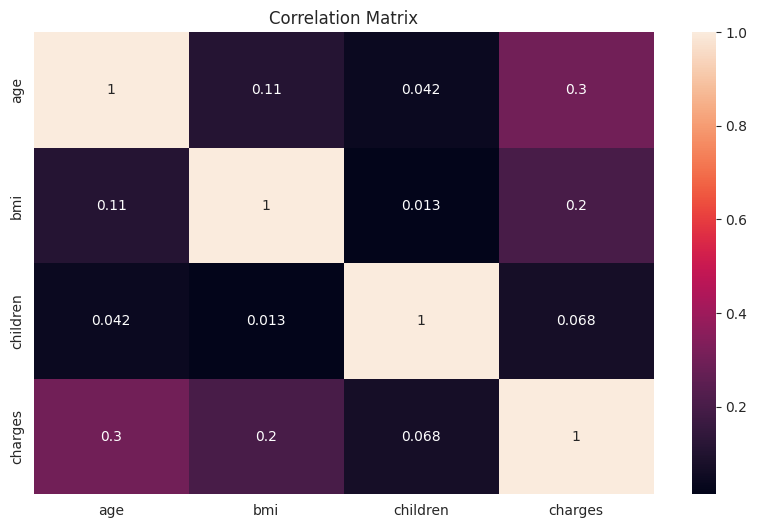

In [8]:
sns.heatmap(dataset.corr(), annot=True)
plt.title("Correlation Matrix")

**Distribution of Bmi**

Scatter plot of BMI values.

---

Since the minimum value is 15, the maximum value is 53, and the standard deviation is 6, I found it appropriate to give bins=7 as a parameter.

Text(0.5, 0, 'BMI')

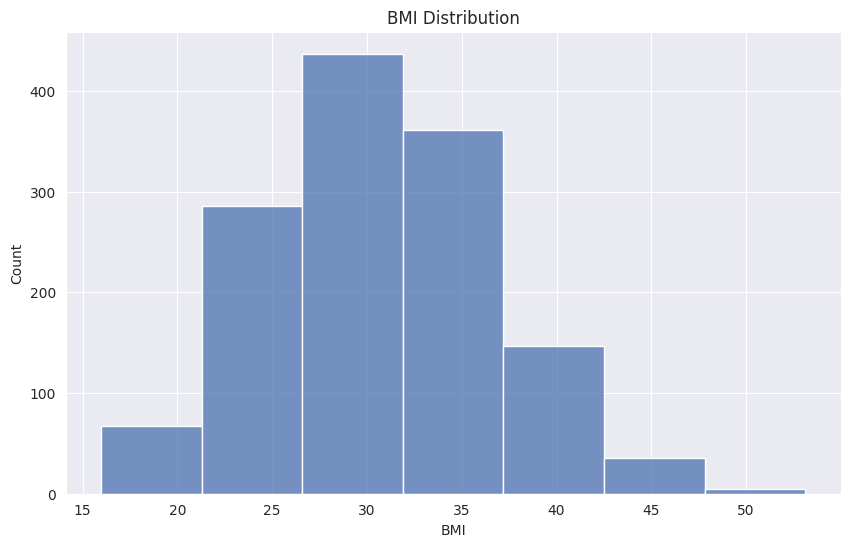

In [9]:
sns.histplot(data=dataset, x="bmi", bins=7)
plt.title("BMI Distribution")
plt.xlabel("BMI")

Outlier BMI values

---


These will need to be normalized later, requiring the Q1 and Q3 values from the section displaying statistics

*Q1=26.29625*
*Q3=34.693750*


Text(0.5, 0, 'BMI')

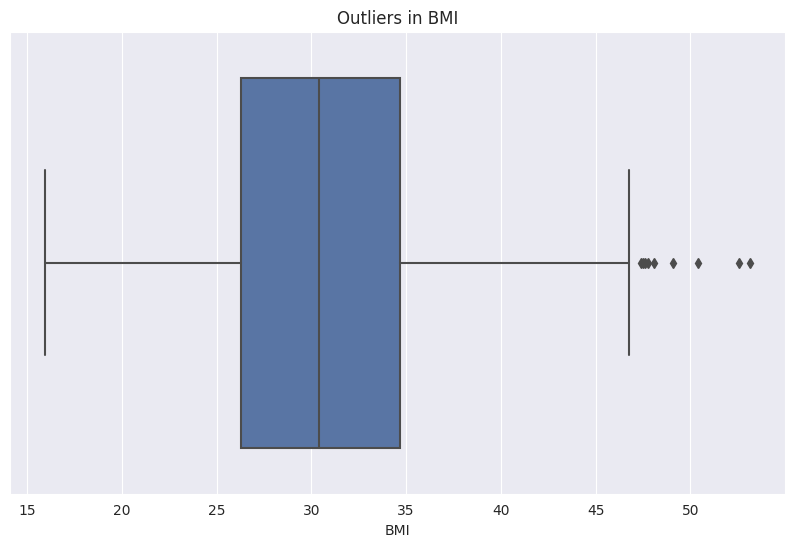

In [10]:
sns.boxplot(data=dataset, x="bmi")
plt.title("Outliers in BMI")
plt.xlabel("BMI")

**Smoker & Charges Relationship**

Number of smokers and non-smokers

In [11]:
dataset["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

Representation of smokers and non-smokers on a strip plot

---
For non-smokers, the charges mostly seem to be in the range of 0-15000

<Axes: xlabel='smoker', ylabel='charges'>

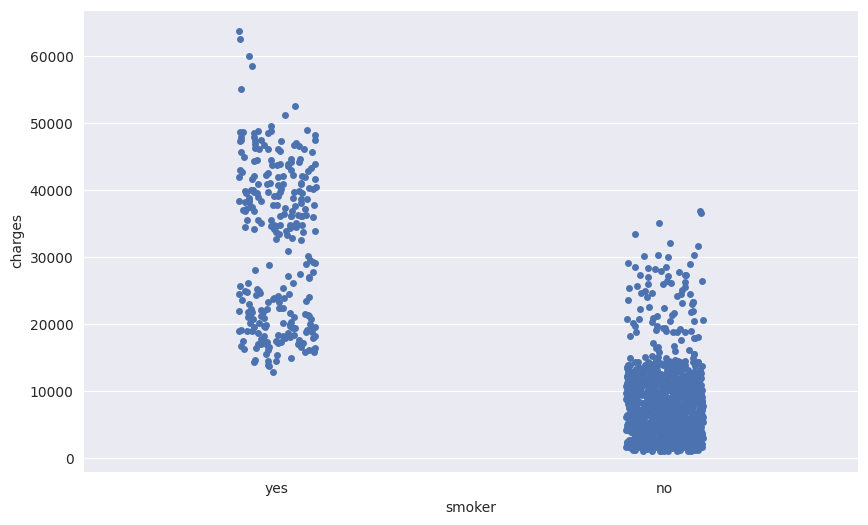

In [12]:
sns.stripplot(x="smoker", y="charges", data=dataset)


**Smoker & Region Relationship**

  The highest number of smokers seems to be in the Southeast, while the number of smokers in other regions is quite similar to each other.

<Axes: xlabel='region', ylabel='count'>

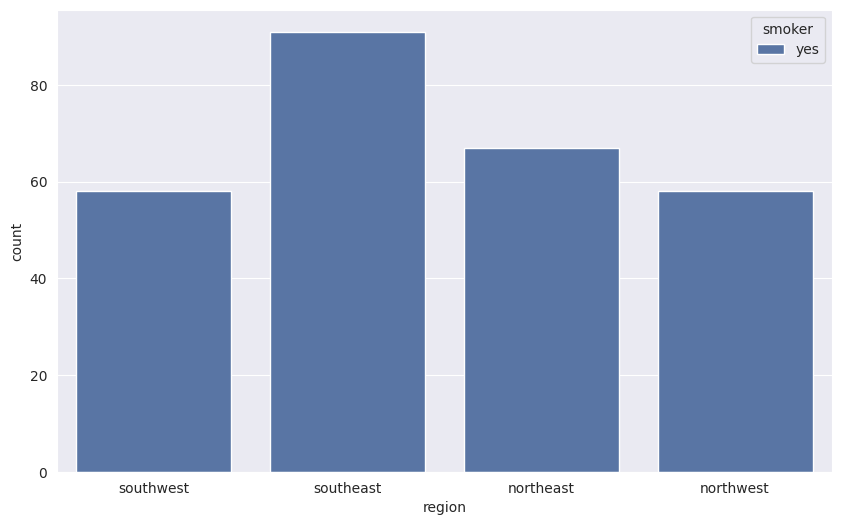

In [13]:
smokers = dataset[dataset["smoker"] == "yes"]
sns.countplot(data=smokers, x="region", hue="smoker")

**BMI & Sex Relationship**

The number of females and males are very close to each other.

In [14]:
dataset["sex"].value_counts()

male      676
female    662
Name: sex, dtype: int64

It seems that there is not much difference between bmi values for women and men. It also appears that the density of the distribution is in the range of 25-35.

<Axes: xlabel='sex', ylabel='bmi'>

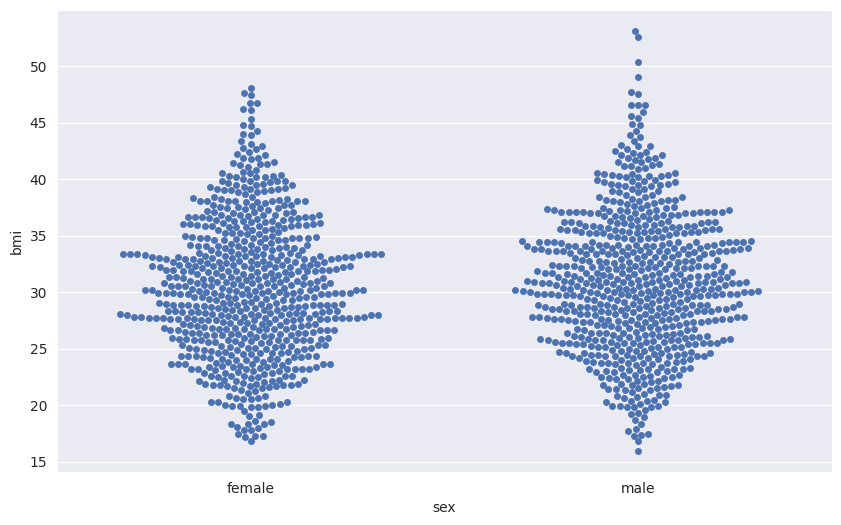

In [15]:
sns.swarmplot(data=dataset, x="sex", y="bmi")


Outlier BMI values for males and females

<Axes: xlabel='sex', ylabel='bmi'>

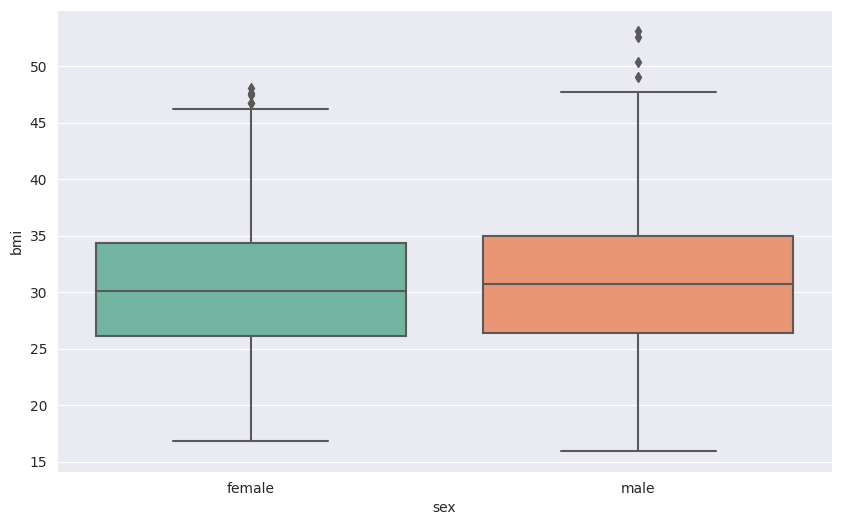

In [16]:
sns.boxplot(data=dataset, x="sex", y="bmi", palette="Set2")


**Region With Most Children**

---

Although there is not much difference between them, the most children are in the southeast.

<ipython-input-17-5dbd4ef3bc4c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset.groupby("region").sum().plot.pie(y="children",autopct="%.2f%%", legend=False)


<Axes: ylabel='children'>

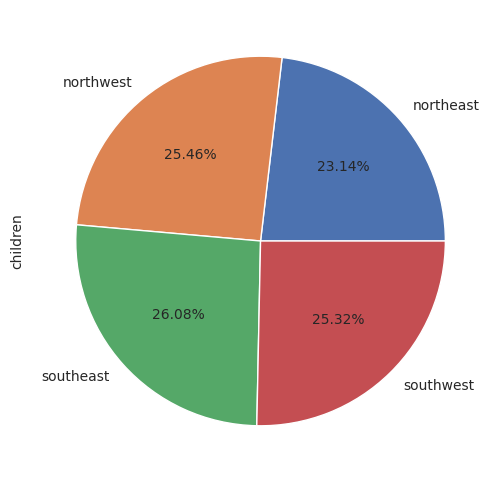

In [17]:
dataset.groupby("region").sum().plot.pie(y="children",autopct="%.2f%%", legend=False)

**Age & BMI Relationship**

Representation of BMI values by age on a scatter plot.


---

To better interpret the data, lines were drawn for the average age and average BMI.
Additionally, since the BMI distribution is observed between 25 and 35 in the box plot, lines were added to this graph at those boundaries as well.

Furthermore, for easier observation, lines were added to represent age intervals as well

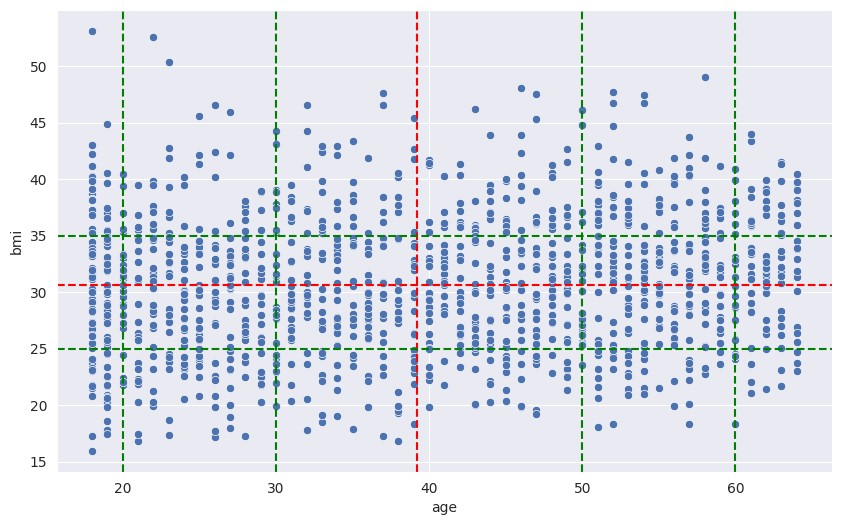

In [18]:
age_mean = 39.207025
bmi_mean = 30.663397
sns.scatterplot(x="age",y="bmi",data=dataset)
plt.axvline(x=age_mean, color = "red", linestyle="--")
plt.axhline(y=bmi_mean, color="red", linestyle="--")
plt.axhline(y=25, color="green", linestyle="--")
plt.axhline(y=35, color="green", linestyle="--")

for i in range(20,70,10):
  if i==40:
    continue
  plt.axvline(x=i, color="green", linestyle="--")
plt.show()

Average BMI values by age.

---
It is observed that after the age range of 36-42, the average BMI value starts to increase as age advances.


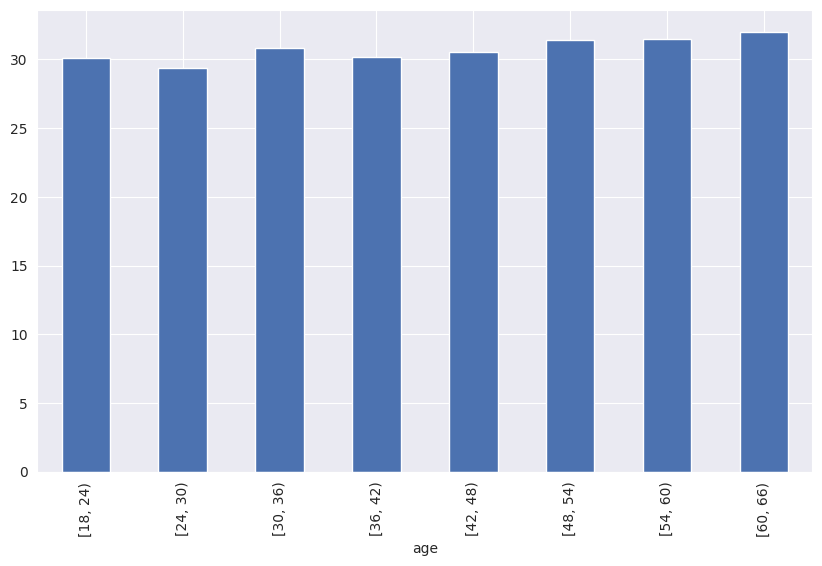

In [19]:
average_bmi_by_age = dataset.groupby(pd.cut(dataset["age"], bins=range(18, 67, 6), right=False))["bmi"].mean().plot.bar()


**Children & BMI Relationship**

Distribution of BMI values based on the number of children.

<Axes: xlabel='children', ylabel='bmi'>

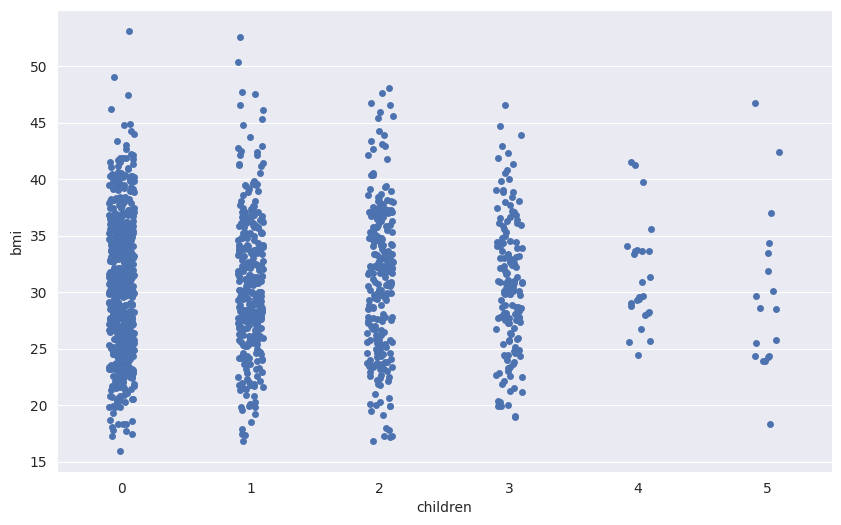

In [20]:
sns.stripplot(x="children", y="bmi", data=dataset)


**BMI & Charges Relationship**

Once again, it can be seen that the density of BMI values is within the range of 0-15,000. Outlier BMI and charges values need to be normalized.


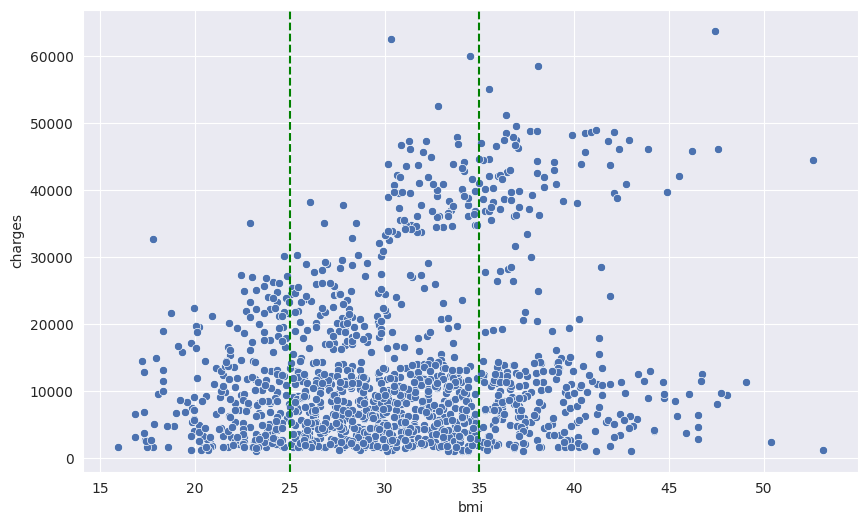

In [21]:
sns.scatterplot(x="bmi", y="charges", data=dataset)
plt.axvline(x=25, color="green", linestyle="--")
plt.axvline(x=35, color="green", linestyle="--")


**Region & BMI & Smoker Relationship**

It appears that smoking doesn't have a significant impact on BMI values across regions.

<Axes: xlabel='region', ylabel='bmi'>

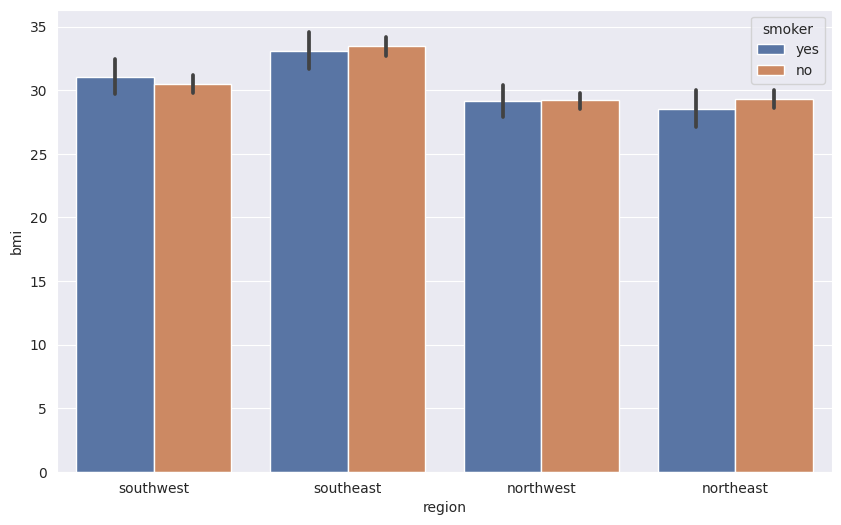

In [22]:
sns.barplot(x="region", y="bmi", hue="smoker", data=dataset)


**Outlier Charges values**


There are a considerable number of outlier charges values; these will need to be normalized.

---
*Q1=4740.28715*
*Q3=16639.912515*


<Axes: xlabel='charges'>

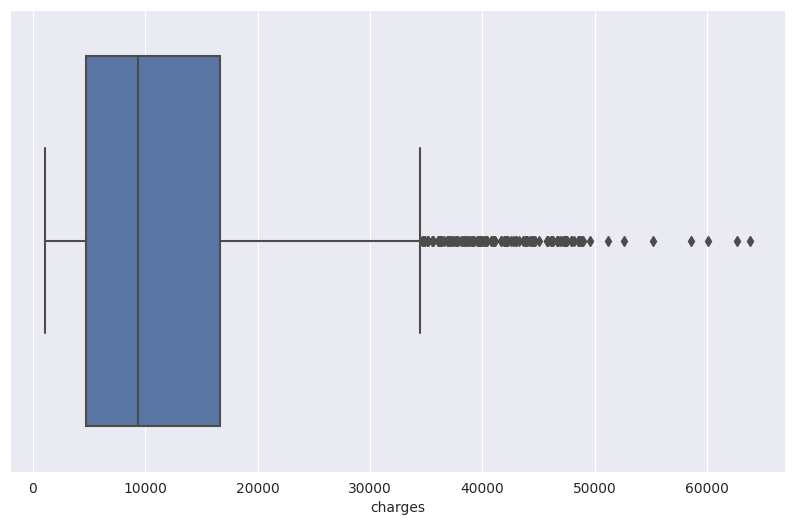

In [23]:
sns.boxplot(data=dataset, x="charges")


# PREPROCESSİNG

**Encoding**

To convert categorical columns in the dataset into numerical format, encoding is required. Since "Sex" and "Smoker" are binary data(male-female/yes-no), label encoding is suitable

In [24]:
label_encoded_features = ["sex", "smoker","region"]
label_encoder = LabelEncoder()

I initially used one-hot encoding for the "Region" feature; however, due to its low correlation and its tendency to introduce noise to the dataset, I had to remove it. Including the "Region" column in the training was resulting in a high MSE value.

In [25]:
for feature in label_encoded_features:
    dataset[feature] = label_encoder.fit_transform(dataset[feature])

In [26]:
#region_encoded = pd.get_dummies(dataset['region'], prefix='region')
#dataset = pd.concat([dataset.drop("region", axis=1), region_encoded], axis=1)


Here, the impact of "region" on "charges" can be observed. Removing this column improves the model's performance.

<Axes: >

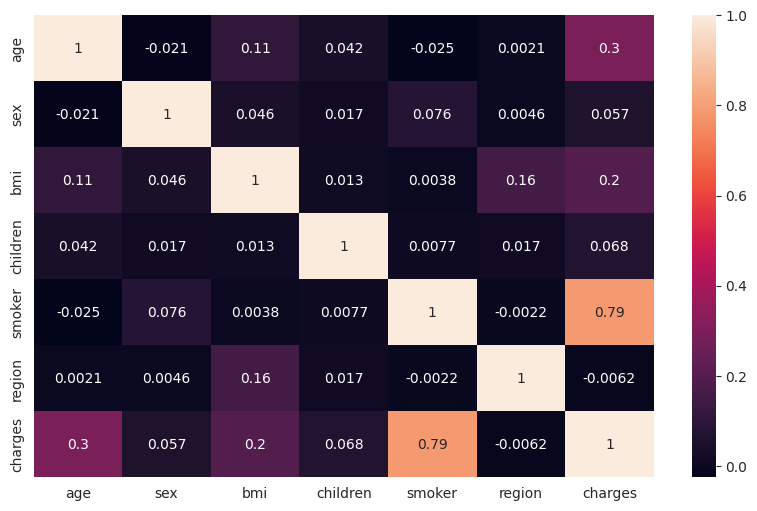

In [26]:
sns.heatmap(dataset.corr(), annot=True)


In [27]:
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


**Normalization**

Outlier BMI and charges data need to be normalized.

---
I've chosen to remove outlier BMI values from the dataset since they are far from realistic and don't align with daily life. As for the outlier charges values, I've capped them to the lower and upper bounds.



---
The previously noted Q1 and Q3 values will be used to determine the bounds.



*Calculating upper and lower bounds for BMI using the formula.*

In [28]:
Q1=26.29625 # we could have calculated this as Q1 = dataset['bmi'].quantile(0.25), but we already have this information at hand
Q3=34.693750
IQR = Q3-Q1

In [29]:
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

Thus, the outlier BMI values are being removed from the dataset.

In [30]:
dataset = dataset[(dataset['bmi'] >= lower) & (dataset['bmi'] <= upper)]

*Calculating upper and lower bounds for charges*

In [31]:
Q1=4740.28715
Q3=16639.912515
IQR = Q3 -Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

Using lambda to cap the values to the lower bound if they are below it, and to the upper bound if they are above it

In [32]:
dataset['charges'] = dataset['charges'].apply(lambda x: lower if x < lower else (upper if x > upper else x))

In [33]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1329.0,39.203913,14.047835,18.0000,27.0000,39.0000,51.00000,64.000000
sex,1329.0,0.504138,0.500171,0.0000,0.0000,1.0000,1.00000,1.000000
bmi,1329.0,30.537348,5.919946,15.9600,26.2200,30.3000,34.48500,46.750000
children,1329.0,1.096313,1.207928,0.0000,0.0000,1.0000,2.00000,5.000000
smoker,1329.0,0.203913,0.403057,0.0000,0.0000,0.0000,0.00000,1.000000
region,1329.0,1.513168,1.106532,0.0000,1.0000,2.0000,2.00000,3.000000
charges,1329.0,12454.235821,10128.672307,1121.8739,4738.2682,9361.3268,16586.49771,34489.350562


**Splitting & Scaling**

In [34]:
X = dataset.drop("charges", axis=1)
X = dataset.drop("region", axis=1)
y = dataset["charges"]

The data has been scaled using StandartScaler.

In [35]:
scaler = StandardScaler()

In [36]:
X = scaler.fit_transform(X)

The dataset has been split into X_train, X_test, y_train, and y_test

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection

The models to be used:

In [38]:
linear = LinearRegression()
tree = DecisionTreeRegressor()
random = RandomForestRegressor()
gradient = GradientBoostingRegressor()
svr = SVR()
ridge = Ridge()
lasso = Lasso()

Training the models

In [39]:
linear.fit(X_train, y_train)
tree.fit(X_train, y_train)
random.fit(X_train, y_train)
gradient.fit(X_train, y_train)
svr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

Lasso()

**Cross Validation**

Splitting the dataset into 10 folds using K-fold and performing cross-validation.

In [40]:
kfold = KFold(n_splits=10, shuffle=True)

In [41]:
linear_scores = cross_val_score(linear, X_train, y_train, scoring='r2', cv=kfold)
tree_scores = cross_val_score(tree, X_train, y_train, scoring='r2', cv=kfold)
random_scores = cross_val_score(random, X_train, y_train, scoring='r2', cv=kfold)
gradient_scores = cross_val_score(gradient, X_train, y_train, scoring='r2', cv=kfold)
svr_scores = cross_val_score(svr, X_train, y_train, scoring='r2', cv=kfold)
ridge_scores = cross_val_score(ridge, X_train, y_train, scoring='r2', cv=kfold)
lasso_scores = cross_val_score(lasso, X_train, y_train, scoring='r2', cv=kfold)

The Lasso Regressor yielded the best performance based on the R2 scores

In [42]:
print("Linear  Cross-Validation R-squared:", linear_scores.mean())
print("Tree  Cross-Validation R-squared:", tree_scores.mean())
print("Random  Cross-Validation R-squared:", random_scores.mean())
print("Gradient  Cross-Validation R-squared:", gradient_scores.mean())
print("SVR  Cross-Validation R-squared:", svr_scores.mean())
print("Ridge Cross-Validation R-squared:", ridge_scores.mean())
print("Lasso Cross-Validation R-squared:", lasso_scores.mean())

Linear  Cross-Validation R-squared: 1.0
Tree  Cross-Validation R-squared: 0.9999463708910168
Random  Cross-Validation R-squared: 0.9999788465145599
Gradient  Cross-Validation R-squared: 0.9999500787871571
SVR  Cross-Validation R-squared: -0.0845634526214627
Ridge Cross-Validation R-squared: 0.9999956297104342
Lasso Cross-Validation R-squared: 0.9999999868642437


# Hyper-Parameter Optimization

Since the model has been selected, GridSearch can be used for hyperparameter optimization. If predefined parameter values are used, this process will be faster.

In [43]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    'max_iter': [100, 500, 1000],
    'tol': [0.0001, 0.001, 0.01]
}

In [44]:
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("En iyi parametreler:", best_params)

En iyi parametreler: {'alpha': 1.0, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0001}


Now that the best parameters have been determined, the model can be retrained, and performance measurements can be conducted.


# Model Evaluation

In [45]:
model = Lasso(alpha=1.0, fit_intercept=True, max_iter=100, tol=0.0001)

In [46]:
model.fit(X_train, y_train)

Lasso(max_iter=100)

In [47]:
predictions = model.predict(X_test)

In [48]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test,predictions)
mae = mean_absolute_error(y_test,predictions)
rmse = np.sqrt(mse)
explained_variance = explained_variance_score(y_test, predictions)

In [49]:
print("MSE:", mse)
print("R2:", r2)
print("MAE:", mae)
print("RMSE:", rmse)
print("Explained Varience", explained_variance)

MSE: 1.3593179272897822
R2: 0.9999999865851525
MAE: 0.9430895877855184
RMSE: 1.1658979060319914
Explained Varience 0.9999999865878353


To determine if there is overfitting in the model, we compare the prediction performance of the training data with that of the test data.

In [50]:
train_predictions = model.predict(X_train)

In [51]:
train_mse = mean_squared_error(y_train, train_predictions)
print("Train_mse:", train_mse)

Train_mse: 1.4096670127711857
